# Use Evolution Strategy to Play BipedalWalker-v3

In [1]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import gym
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('BipedalWalker-v3', new_step_api=True)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

def clip_reward(reward):
    return np.clip(reward, -1., 1.)
reward_clipped_env = gym.wrappers.TransformReward(env, clip_reward)

09:04:46 [INFO] env: <BipedalWalker<BipedalWalker-v3>>
09:04:46 [INFO] action_space: Box(-1.0, 1.0, (4,), float32)
09:04:46 [INFO] observation_space: Box(-inf, inf, (24,), float32)
09:04:46 [INFO] reward_range: (-inf, inf)
09:04:46 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}
09:04:46 [INFO] _max_episode_steps: 1600
09:04:46 [INFO] _elapsed_steps: None
09:04:46 [INFO] id: BipedalWalker-v3
09:04:46 [INFO] entry_point: gym.envs.box2d:BipedalWalker
09:04:46 [INFO] reward_threshold: 300
09:04:46 [INFO] nondeterministic: False
09:04:46 [INFO] max_episode_steps: 1600
09:04:46 [INFO] _kwargs: {}
09:04:46 [INFO] _env_name: BipedalWalker


In [3]:
def play_episode(env, agent, seed=None, mode=None, render=False):
    observation = env.reset(seed=seed)
    reward, termination, truncation = 0., False, False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, termination)
        if render:
            env.render()
        if termination or truncation:
            break
        observation, reward, termination, truncation, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
    agent.close()
    return episode_reward, elapsed_steps

In [4]:
class ESAgent:
    def __init__(self, env=None, weights=None, bias=None):
        if weights is not None:
            self.weights = weights
        else:
            self.weights = np.zeros((env.observation_space.shape[0],
                    env.action_space.shape[0]))
        if bias is not None:
            self.bias = bias
        else:
            self.bias = np.zeros(env.action_space.shape[0])

    def reset(self, mode=None):
        pass

    def close(self):
        pass

    def step(self, observation, reward, termination):
        action = np.matmul(observation, self.weights)
        return action

    def train(self, env, scale=0.05, learning_rate=0.2, population=16):
        # permulate weights
        weight_deltas = [scale * np.random.randn(*agent.weights.shape) for _ in
                range(population)]
        bias_deltas = [scale * np.random.randn(*agent.bias.shape) for _ in
                range(population)]

        # calculate rewards
        agents = [ESAgent(weights=self.weights + weight_delta,
                bias=self.bias + bias_delta) for weight_delta, bias_delta in
                zip(weight_deltas, bias_deltas)]
        rewards = np.array([play_episode(env, agent)[0] for agent in agents])

        # standardize the rewards
        std = rewards.std()
        if np.isclose(std, 0):
            coeffs = np.zeros(population)
        else:
            coeffs = (rewards - rewards.mean()) / std

        # update weights
        weight_updates = sum([coeff * weight_delta for coeff, weight_delta in
                zip(coeffs, weight_deltas)])
        bias_updates = sum([coeff * bias_delta for coeff, bias_delta in
                zip(coeffs, bias_deltas)])
        self.weights += learning_rate * weight_updates / population
        self.bias += learning_rate * bias_updates / population


agent = ESAgent(env=env)

09:04:46 [INFO] ==== train & evaluate ====
09:04:48 [INFO] evaluate generation 0: reward = -92.19, steps = 109
09:04:51 [INFO] evaluate generation 1: reward = -92.18, steps = 111
09:04:57 [INFO] evaluate generation 2: reward = -92.18, steps = 110
09:05:02 [INFO] evaluate generation 3: reward = -92.05, steps = 108
09:05:05 [INFO] evaluate generation 4: reward = -92.13, steps = 104
09:05:12 [INFO] evaluate generation 5: reward = -92.13, steps = 104
09:05:17 [INFO] evaluate generation 6: reward = -92.21, steps = 103
09:05:21 [INFO] evaluate generation 7: reward = -92.01, steps = 102
09:05:26 [INFO] evaluate generation 8: reward = -92.37, steps = 99
09:05:30 [INFO] evaluate generation 9: reward = -92.47, steps = 97
09:05:34 [INFO] evaluate generation 10: reward = -92.55, steps = 98
09:05:37 [INFO] evaluate generation 11: reward = -92.52, steps = 100
09:05:41 [INFO] evaluate generation 12: reward = -92.35, steps = 101
09:05:44 [INFO] evaluate generation 13: reward = -92.59, steps = 97
09:05

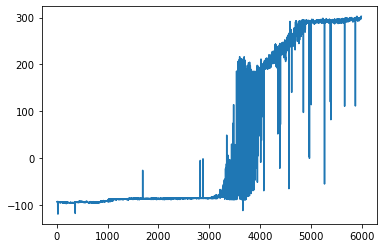

In [5]:
logging.info('==== train & evaluate ====')
episode_rewards = []
for generation in itertools.count():
    agent.train(reward_clipped_env)
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.info('evaluate generation %d: reward = %.2f, steps = %d',
            generation, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > env.spec.reward_threshold:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.info('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))